In [2]:
import sys
nb_out = sys.stdout

In [91]:
import tsaugmentation as tsag
sys.stdout = nb_out
import matplotlib.pyplot as plt
from itertools import product
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

In [4]:
data = tsag.preprocessing.PreprocessDatasets('tourism').apply_preprocess()

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [5]:
train = data['train']['data']

In [6]:
train

array([[ 307, 2142,  202, ...,    3,    0,    5],
       [ 367,  609,  159, ...,    0,    0,    1],
       [ 543,  388,  100, ...,    0,    0,    2],
       ...,
       [ 589,  272,  174, ...,   15,    1,    0],
       [ 507,  269,  304, ...,    0,    1,    0],
       [ 768,  222,   72, ...,    2,    1,    0]])

# Build the SUM Matrix

The SUM matrix to build:

$$ \begin{matrix} 1 & 1 & 1& 1 \\
1 & 1 & 0 & 0 \\
0 & 0 & 1 & 1\\
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1\end{matrix}$$

In [7]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [223]:
groups = []
for group in data['train']['groups_names'].keys():
    groups.append(data['train']['groups_names'][group][data['train']['groups_idx'][group]].reshape(-1,1))

In [224]:
groups_arr = np.squeeze(np.array(groups)).T

In [225]:
enc = OneHotEncoder().fit(groups_arr)

In [226]:
# SUM Matrix
S = np.concatenate((
    np.ones(data['train']['s']).reshape(1,-1),
    enc.transform(groups_arr).toarray().T,
    np.eye(data['train']['s'])),
    axis=0
)

In [227]:
visitors_train = (S @ train.T).T

In [228]:
S

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Static Graph Temporal Signal

### Extract the node features

Features for each node:
- Average number of visits at that node
- Number of connections (e.g. top node has 4 connections -> state, zone, region, purpose)

Only use train data to avoid leaking information into the train set. 

In [36]:
average_node_visitors = visitors_train.mean(axis=0)
count_node_connections = A.sum(axis=1)

In [37]:
# Normalize features between 0 and 1
average_node_visitors = (average_node_visitors - np.min(average_node_visitors)) / (np.max(average_node_visitors) - np.min(average_node_visitors))
count_node_connections = (count_node_connections - np.min(count_node_connections)) / (np.max(count_node_connections) - np.min(count_node_connections))

In [38]:
node_features = np.concatenate((average_node_visitors.reshape(-1,1), count_node_connections.reshape(-1,1)), axis=1)

In [39]:
node_features.shape

(419, 2)

In [42]:
node_features[:20]

array([[1.        , 1.        ],
       [0.31919814, 0.18151815],
       [0.19545039, 0.27392739],
       [0.26144788, 0.15511551],
       [0.06955159, 0.15511551],
       [0.09909199, 0.06270627],
       [0.03128532, 0.06270627],
       [0.0236574 , 0.08910891],
       [0.09275328, 0.02310231],
       [0.08784076, 0.02310231],
       [0.04025019, 0.00990099],
       [0.03631043, 0.04950495],
       [0.04227172, 0.04950495],
       [0.01950734, 0.00990099],
       [0.09064624, 0.03630363],
       [0.01762422, 0.00990099],
       [0.02553969, 0.03630363],
       [0.03132767, 0.07590759],
       [0.03010104, 0.10231023],
       [0.14830333, 0.03630363]])

# Build the Graph

In [588]:
states = [list(v) for k, v in data['train']['groups_names'].items() if k in ('state')][0]
zones = [list(v) for k, v in data['train']['groups_names'].items() if k in ('zone')][0]
regions = [list(v) for k, v in data['train']['groups_names'].items() if k in ('region')][0]
purposes = [list(v) for k, v in data['train']['groups_names'].items() if k in ('purpose')][0]

In [589]:
def build_graph(states, zones, regions, purposes):
    """
    Creates a graph based on the lists passed as arguments
    It is not yet generalized for any dataset
    """
    G = nx.Graph()

    hm_state_nodes = {}
    hm_zone_nodes = {}
    hm_purpose_nodes = {}
    hm_region_nodes = {}

    node_id = 0
    G.add_node(node_id, name='total')
    node_id += 1
    for idx_purpose, purpose_node in enumerate(purposes):
        G.add_node(node_id, name=purpose_node)
        G.add_edge(0, node_id)
        # hashmap purpose_id -> node_id
        hm_purpose_nodes[idx_purpose] = node_id
        node_id += 1
    for idx_state, state_node in enumerate(states):
        G.add_node(node_id, name=state_node)
        G.add_edge(0, node_id)
        # hashmap state_id -> node_id
        hm_state_nodes[idx_state] = node_id
        node_id += 1
        for idx_zone, zone_node in enumerate(zones):
            if state_node[0] == zone_node[0]:
                G.add_node(node_id, name=zone_node)
                G.add_edge(hm_state_nodes[idx_state], node_id)
                # hashmap zone_id -> node_id
                hm_zone_nodes[idx_zone] = node_id
                node_id += 1
                for idx_region, region_node in enumerate(regions):
                    if zone_node[:2] == region_node[:2]:
                        G.add_node(node_id, name=region_node)
                        G.add_edge(hm_zone_nodes[idx_zone], node_id)
                        # hashmap region_id -> node_id
                        hm_region_nodes[idx_region] = node_id
                        node_id += 1
    for idx_purpose, purpose_node in enumerate(purposes):
        for idx_region, region_node in enumerate(regions):
            G.add_node(node_id, name=purpose_node + '_' + region_node)
            G.add_edge(hm_purpose_nodes[idx_purpose], node_id)
            G.add_edge(hm_region_nodes[idx_region], node_id)
            node_id += 1
    return G
            
            
def flatten_dict(input_dict):
    """
    Recursion function to flatten dictionaries
    """
    flat_dict = {}
    for idx, element in input_dict.items():
        if type(element) is dict:
            flat_dict[idx] = flatten_dict(element)
        else:
            return element
    return flat_dict

def plot_graph_hierarchical(G):
    labels = flatten_dict(dict(G.nodes.data()))
    
    _, ax = plt.subplots(1,1, figsize=(20, 10))
    ax.set_title('Grouping Structure Graph')
    pos=graphviz_layout(G, prog='dot')
    nx.draw(G, pos, labels=labels, with_labels=True)
    plt.show()

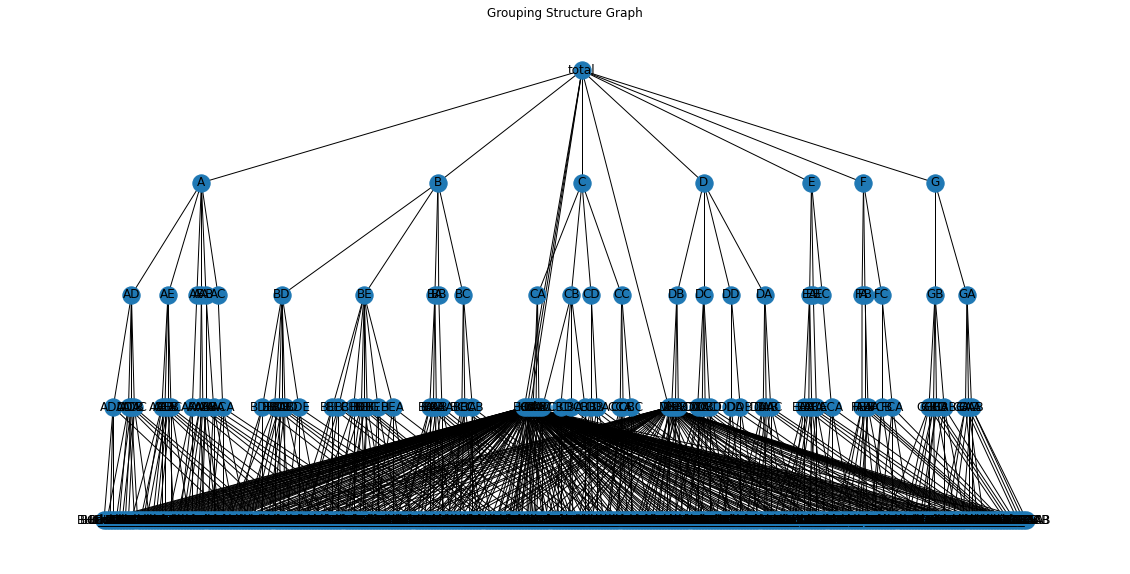

In [590]:
G = build_graph(states, zones, regions, purposes)
plot_graph_hierarchical(G)

# Drawing a subset of the graph

In [576]:
states = states[:2]
zones = zones[:8]
regions = regions[:16]
purposes = purposes[:2]

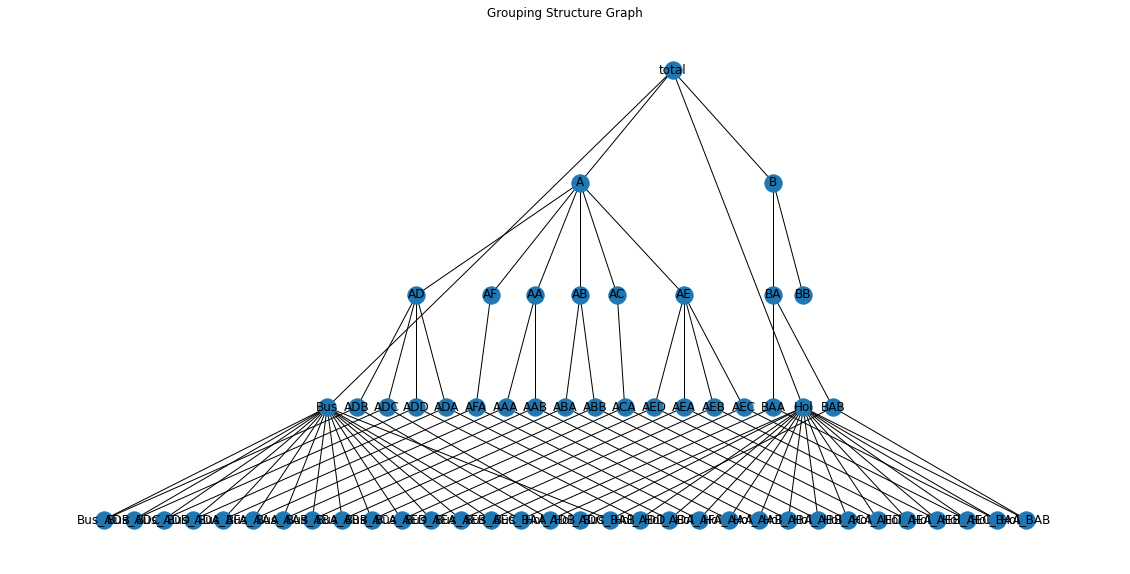

In [577]:
G = build_graph(states, zones, regions, purposes)
plot_graph_hierarchical(G)

# Extract the edges

In [602]:
edge_list = []
for edge_data in list(G.edges.data()):
    edge = []
    edge.append(edge_data[0])
    edge.append(edge_data[1])
    edge_list.append(edge)
edge_index = np.array(edge_list).T

In [603]:
edge_index.shape

(2, 722)